In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stix2.v21 import (ThreatActor, Identity, AttackPattern, Campaign, IntrusionSet, Relationship, ExternalReference, Bundle, Grouping)
from efficient_apriori import apriori
import re
from pyattck import Attck
import requests
import json
from stix2 import MemoryStore, Filter
from neo4j import GraphDatabase
from collections import Counter
import seaborn as sns

In [3]:
# Settings Values - for Apriori Algorithm
# TODO - 2: Do we need to adjust these numbers, in order to refine our algorithm metrics??
confidenceLevel = 0.70
supportLevel = 0.05
abstract = True

In [4]:
def NameToCode(gName):
    # create an instance of the Attck class
    attck = Attck()

    # get all APT groups in the framework
    apt_groups = attck.enterprise.actors

    # create a dictionary mapping APT group names to G codes
    group_to_gcode = {}
    for group in apt_groups:
        if group.name == gName:
            gcode = group.id
            return gcode
    return ""


In [5]:
def GenerateTestSet():
    df = pd.read_csv("datasets/Categorized_Adversary_TTPs.csv").loc[:, ['mitre_attack_name', 'mitre_attack_ttps']] # sample dataset of attacks
    test_threat_profiles = {}
    for row in df.values:
        gcode = NameToCode(row[0].strip())
        tcodes = (row[1].strip("'][").replace("'","").split(', '))
        test_threat_profiles[gcode] = tcodes
    
    return test_threat_profiles
    
def GenerateAprioriLists():

    #Data from Scott at Tidal Cyber
    ttpLists = []
    df1 = json.load(open("datasets/TidalCyberData/otx_running.json")) [1:]
    for row in df1:
        if len(row[7]) > 0 and type(row[7]) == type([]):
            ttpLists.append(["'" + ttp + "'" for ttp in row[7]])
    
    df2 = json.load(open("datasets/TidalCyberData/Tidal OSINT Technique Extraction.json"))
    for row in df2:
        if len(row['Tidal Extracted Techniques']) > 0:
            ttpLists.append(["'" + ttp2 + "'" for ttp2 in row['Tidal Extracted Techniques']])
    # Some data comes from this dataset with TTPs

    # More data is gained by using attck data from tool and malware TTPs
    attack = Attck()
    
    malwares = attack.enterprise.malwares + attack.enterprise.tools
    
    for malware in malwares:
        ttpLists.append(["'" + ttp.id + "'" for ttp in malware.techniques])

    # To use the apriori we need to generate a list of lists
    aprList = ttpLists
    # for row in df3.values:
    #     aprList.append((row[13].strip('][').split(', ')))

    # get rid of empty sets
    return [ttp for ttp in aprList if len(ttp) > 1]

In [6]:
def AbstractTTPs(ttpList):
    # Take sub-techniques and remove the .### to abstract them to parent techniques 
    for i in range(0,len(ttpList)):
        ttpList[i] = [re.sub(r'\.[0-9]+', '', ttp) for ttp in ttpList[i]]
    return ttpList 

In [53]:
# takes a list of lists and returns a list of rules sorted by size 
def AprioriMining(aprList, confidenceLevel=confidenceLevel):
    # Perform apriori rule association mining
    itemsets, rules = apriori(aprList, min_support=supportLevel, min_confidence=confidenceLevel)
    
    # Sort by size to get the 1:1 mappings first and so on. 
    ruleNums = np.array([len(rule.lhs+rule.rhs) for rule in rules])
    rules = np.array(rules)
    inds = ruleNums.argsort()[::]
    rules = rules[inds]
    
    # Maximum rule size of 4 to limit number of rules, any rules with size > 4 are redundant anyways
    rules = [x for x in filter(lambda rule: len(rule.lhs+rule.rhs) <= 4, rules)]
    return rules

In [8]:
# Downloads latest MITRE framework from the branch
def get_data_from_branch(domain):
    """get the ATT&CK STIX data from MITRE/CTI. Domain should be 'enterprise-attack', 'mobile-attack' or 'ics-attack'. Branch should typically be master."""
    stix_json = requests.get(f"https://raw.githubusercontent.com/mitre-attack/attack-stix-data/master/{domain}/{domain}.json").json()
    return MemoryStore(stix_data=stix_json["objects"])

src = get_data_from_branch("enterprise-attack")

In [9]:
# Get TTPs from seed, where seed is an APT group code: GXXXX
def ExtractSeedTTPs(seed):
    seeds = []
    # This runs but says that "actors" is not found
    actor = actors[seed]
    for ttp in actor.techniques:
        seeds.append(ttp.id)
        
    # If we are using abstracted TTPs then remove sub technique
    if (abstract):
        for i in range(0, len(seeds)):
            seeds[i] = re.sub(r'\.[0-9]+', '', seeds[i])
    return seeds

In [10]:
def ExportBundle(bundle, filename):
    with open(filename, "w") as f:
        f.write(bundle.serialize())
        f.close()

In [27]:
# Each rule has a confidence, lift, support, lhs, rhs, conviction, rule power factor (RPF), 

# dictionaries to optimize requests
ttpDictionary = {}

# Takes an APTGroup and generates hypothesized relationships and attack pattern objects
# Returns a tuple of: (profile, attackPatterns, relationships, attackPatterns)
def CreateRelationships(seeds, rules):
    profile = {} #stores the TTP and tactic for easy logging
    seen = [] #stores TTPs that have been seen by the algorithm
    attackPatterns = {} #stores generated attack pattern objects
    relationships = {} # stores generated relationship objects
    # attackPatterns = {} # stores generated grouping objects

    # Get seeds out of the APT group
    # seeds = ExtractSeedTTPs(APTGroup)
    # seeds = ["T1566", "T1204"]
    
#     # Perform Association Rule Mining
#     rules = AprioriMining(aprioriLists) 
    
    # Add seeds to activity-attack-graph as nodes
    for seed in seeds:
       ## print(seed)
        profile[seed] = 1
        ttp = 0
        # Get the stix object for the TTP
        if (not(seed in list(ttpDictionary.keys()))):
            try:          
                ttp = src.query([ Filter("external_references.external_id", "=", seed) ])[0]
                ttpDictionary[seed] = ttp
            except:
                continue
        else:
            ttp = ttpDictionary[seed]
            
        if (ttp != 0):
        # Create and add objects to lists, context is used to identify seeds from hypothesized events
            attackPatterns[seed] = ttp
    
    # print(profile)
    
    seedTotals = ["'"+x+"'" for x in seeds]
    # Use a queue to iterate through and create a tree of TTPs
    while len(seeds) > 0:
        for rule in rules:
            # Check to see if the left hand side of a rule is satisfied 
            if "'"+seeds[0]+"'" in rule.lhs and set(rule.lhs).issubset(seedTotals):
                # If the lhs is satisfied, then loop through each TTP in the rhs 
                for ttpName in rule.rhs:
                    # If this TTP hasn't been visited already then create STIX objects
                    if ttpName not in seen:
                        if (not(ttpName[1:-1] in ttpDictionary.keys())):
                            ttp = src.query([ Filter("external_references.external_id", "=", ttpName[1:-1]) ])[0]
                            ttpDictionary[ttpName[1:-1]] = ttp
                        else:
                            ttp = ttpDictionary[ttpName[1:-1]]
                        # rule tactics 
                        tactics = []
                        for i in ttp['kill_chain_phases']:
                            tactics.append(i['phase_name'])
                        
                        # create a new grouping object with the rule name. 
                        
                        attackPatterns[ttpName[1:-1]] = ttp
                        seedTotals.append(ttpName)
                        seen.append(ttpName)
                        seeds.append(ttp['external_references'][0]['external_id'])

                    # if the relationship already exists between two objects then we take the one with higher confidence
                    # make sure the exact relationship does not alraedy exist
                    if not (attackPatterns[seeds[0]]['id'], attackPatterns[ttpName[1:-1]]['id']) in relationships:
                        # if the opposite relationship exists then choose the one with the highest confidence to add
                        # we do this because if we do not then on the graph there will be two arrows going opposite directions to connect the same 2 TTPs
                        # this causes clutter and makes the confidence values unreadable since they will be layered on top of each other
                        if (attackPatterns[ttpName[1:-1]]['id'], attackPatterns[seeds[0]]['id']) in relationships:
                            # if existing relationship has higher confidence, move on
                            if float(relationships[(attackPatterns[ttpName[1:-1]]['id'], attackPatterns[seeds[0]]['id'])]['relationship_type']) > rule.confidence:
                                continue # move to next iteration of for loop, so code after this statement won't execute
                            # if existing relationship has lower confidence, delete it and let the new relationship take it's place
                            else:
                                del relationships[(attackPatterns[ttpName[1:-1]]['id'], attackPatterns[seeds[0]]['id'])]
                        relationships[(attackPatterns[seeds[0]]['id'], attackPatterns[ttpName[1:-1]]['id'])] = Relationship(attackPatterns[seeds[0]]['id'], str(round(rule.confidence, 3)), attackPatterns[ttpName[1:-1]]['id'])
                        if not((ttpName[1:-1] in profile.keys() and profile[ttpName[1:-1]] >= 1)):
                            profile[ttpName[1:-1]] = round(rule.confidence, 3)
 
        # pop to progress the queue
        seeds.pop(0) 
    
    for seed in seeds:
        profile[seed] = 1
        

    return (profile, attackPatterns, relationships)

In [16]:
aprioriList = AbstractTTPs(GenerateAprioriLists()) # generate lists for apriori

In [17]:
intelSeed = ["T1566", "T1204"] # Use-case: Observed TTPs
profile, attackPatterns, relationships = CreateRelationships(intelSeed, aprioriList)

In [18]:
# Displays the results of the Apiori Algorithm 
print(relationships)

# This is the hypothesized profile
apt_x = profile

{('attack-pattern--a62a8db3-f23a-4d8f-afd6-9dbc77e7813b', 'attack-pattern--7385dfaf-6886-4229-9ecd-6fd678040830'): Relationship(type='relationship', spec_version='2.1', id='relationship--5c0cb999-d8df-48e3-bd0f-f5ec902fdeff', created='2023-04-03T03:25:22.039365Z', modified='2023-04-03T03:25:22.039365Z', relationship_type='0.7', source_ref='attack-pattern--a62a8db3-f23a-4d8f-afd6-9dbc77e7813b', target_ref='attack-pattern--7385dfaf-6886-4229-9ecd-6fd678040830', revoked=False), ('attack-pattern--355be19c-ffc9-46d5-8d50-d6a036c675b6', 'attack-pattern--7385dfaf-6886-4229-9ecd-6fd678040830'): Relationship(type='relationship', spec_version='2.1', id='relationship--99aa7c9f-68f8-4fde-a329-0110940430cb', created='2023-04-03T03:25:22.310366Z', modified='2023-04-03T03:25:22.310366Z', relationship_type='0.817', source_ref='attack-pattern--355be19c-ffc9-46d5-8d50-d6a036c675b6', target_ref='attack-pattern--7385dfaf-6886-4229-9ecd-6fd678040830', revoked=False), ('attack-pattern--355be19c-ffc9-46d5-8d

In [47]:
# Phase 2: Make APT Threat Profiles
attack = Attck()

# Dictionary to hold all the threat profiles. 
# The key is a given APT and the values are a list of TTPs
threat_profiles = {}
threat_profiles = json.load(open("datasets/ThreatProfiles/threat_profiles.json"))
# for actor in attack.enterprise.actors:
#     technique_dict = {}
#     for technique in actor.techniques:
#         technique_dict[technique.id[0:5]] = 1
#     threat_profiles[actor.id] = technique_dict
    
# TODO: Add extended_threat profiles
# Create threatprofile Seed -- need to parse the value of the keys.
extended_threat_profiles = {}
extended_threat_profiles = json.load(open("datasets/ThreatProfiles/extended_threat_profiles.json"))
# for apt, t_codes in threat_profiles.items():
#     ttp_list = list(t_codes.keys())
#     profile, attackPatterns, relationships = CreateRelationships(ttp_list, aprioriList)
#     extended_threat_profiles[apt] = profile

print(extended_threat_profiles["G0085"])



{'T1114': 1, 'T1078': 1, 'T1566': 1, 'T1056': 1, 'T1204': 1, 'T1059': 1, 'T1564': 1, 'T1071': 1, 'T1090': 1, 'T1027': 0.719, 'T1082': 0.778, 'T1083': 0.704}


In [26]:
# Phase 2: WEIGHTED JACCARD SIMILARITY
# Side note: Find a way to relate techniques and sub-techniques. 

# TODO: Create a function that compares two threat profiles and produces a Weighted Jaccard. Just returns a number. 
def weighted_jac (profile1, profile2):

    # Extract the keys as sets
    keys1 = set(profile1.keys())
    keys2 = set(profile2.keys())

    # Calculate the Jaccard index
    # Only need the normal intersection and union
    intersection = keys1.intersection(keys2)
    union = keys1.union(keys2)
    # jaccard_index = len(intersection) / len(union)

    # Weight the Jaccard index by the values in the dictionaries
    weighted_intersection = sum(min(profile1[k], profile2[k]) for k in intersection)
    weighted_union = sum(max(profile1.get(k, 0), profile2.get(k, 0)) for k in union)
    
    try:
        weighted_jaccard_index = weighted_intersection / weighted_union
    except:
        print(profile1)
        print(profile2)
        return 0
        
    return weighted_jaccard_index
    #print("Weighted Jaccard index:", weighted_jaccard_index)


In [25]:
# TODO: Create another function that calls the previous function on all of the threat profiles and our threat profile of interest.
# We could do some sort of ranking like list the APTs with the highest Weighted Jaccard first. 
def compare_apt(h_threatprofile, threat_profiles):
    # Make another dictionary 
    rankings = {}
    
    for key, value in threat_profiles.items(): 
        similarity  = (weighted_jac(value, h_threatprofile)) * 100
        percentage = round(similarity, 2)
        rankings[key] = percentage
    
    return rankings

In [22]:
compare_apt_dict = compare_apt(apt_x, extended_threat_profiles)

# SORTED -- NICE!
sorted_dict = dict(sorted(compare_apt_dict.items(), key=lambda x: x[1], reverse=True))
print(sorted_dict)


{'G0013': 99.73, 'G0103': 92.97, 'G0062': 79.06, 'G0084': 64.97, 'G0005': 61.99, 'G0133': 59.01, 'G0066': 58.58, 'G0075': 58.16, 'G0137': 56.31, 'G0130': 55.45, 'G0136': 54.24, 'G0079': 53.32, 'G0048': 49.45, 'G0089': 48.12, 'G0099': 46.22, 'G0095': 44.69, 'G0085': 43.67, 'G0090': 42.26, 'G0127': 41.66, 'G0115': 38.72, 'G0070': 36.88, 'G0120': 36.65, 'G1003': 36.16, 'G0098': 35.69, 'G0140': 35.65, 'G1011': 35.21, 'G0086': 34.28, 'G0134': 34.27, 'G0021': 34.09, 'G0107': 33.46, 'G0018': 32.51, 'G0138': 32.2, 'G0112': 31.69, 'G0068': 31.41, 'G1007': 29.88, 'G1008': 29.61, 'G0142': 29.26, 'G0078': 28.99, 'G0019': 28.81, 'G0131': 28.62, 'G0056': 28.34, 'G1002': 27.9, 'G0073': 26.1, 'G0043': 24.72, 'G0071': 24.0, 'G0001': 23.47, 'G0100': 22.83, 'G0033': 22.36, 'G0026': 22.25, 'G0054': 21.82, 'G0128': 21.39, 'G0121': 21.27, 'G0012': 20.72, 'G0124': 20.33, 'G0009': 20.31, 'G0064': 19.77, 'G0126': 19.46, 'G0119': 19.24, 'G0092': 18.68, 'G1009': 18.42, 'G0006': 18.41, 'G0143': 18.0, 'G0061': 17.

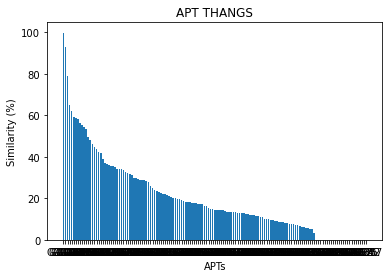

In [24]:
# Make some sort of visualization
import matplotlib.pyplot as plt

# Example dictionary
data = sorted_dict

# Extract keys and values from dictionary
labels = list(data.keys())
values = list(data.values())

# Create a bar chart using matplotlib
plt.bar(labels, values)

# Set chart title and axis labels
plt.title('APT THANGS')
plt.xlabel('APTs')
plt.ylabel('Similarity (%)')

# Display the chart
plt.show()


In [25]:
# Write the dictionary to a JSON file
# import json

# with open("Extended_Threat_Profiles", "w") as outfile:
#     json.dump(extended_threat_profiles, outfile)

In [80]:
# Generate heatmap right here
# create matrix using pandas dataset with rows and columns being APT groups

# some threat groups have no TTPs, we will filter those out

heatdf_tgroups = {}
for gcode, prof in extended_threat_profiles.items():
    if (prof != {}):
        heatdf_tgroups[gcode] = prof

aptGroups = list(heatdf_tgroups.keys())

heatdf = pd.DataFrame(columns=aptGroups)
# populate the dataframe
for gcode, prof in heatdf_tgroups.items():
    for gcode2, prof2 in heatdf_tgroups.items():
        simularity = int(weighted_jac(prof, prof2)*100)
        heatdf.loc[gcode, gcode2] = simularity

heatdf = heatdf.reset_index(drop=True).astype(int)


In [81]:
heatdf

,G0032,G0069,G0045,G0086,G0125,G0085,G0019,G0087,G0016,G0005,...,G0105,G0075,G0023,G0124,G0133,G0025,G0137,G0002,G0063,G0036
0,100,37,36,10,13,12,17,32,35,8,...,7,10,1,8,10,2,11,1,1,2
1,37,100,44,16,21,14,28,40,41,15,...,5,18,0,12,15,2,19,2,2,1
2,36,44,100,21,21,21,32,47,39,14,...,6,20,0,13,17,2,21,2,2,4
3,10,16,21,100,17,43,23,23,14,28,...,8,27,0,15,28,0,27,5,5,13
4,13,21,21,17,100,21,14,20,21,11,...,3,24,0,9,17,4,19,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,2,2,2,0,4,0,0,0,1,0,...,0,0,0,0,0,100,10,0,0,0
129,11,19,21,27,19,32,35,18,12,41,...,10,48,0,15,64,10,100,8,8,7
130,1,2,2,5,3,6,4,2,1,8,...,0,8,0,0,8,0,8,100,100,0
131,1,2,2,5,3,6,4,2,1,8,...,0,8,0,0,8,0,8,100,100,0


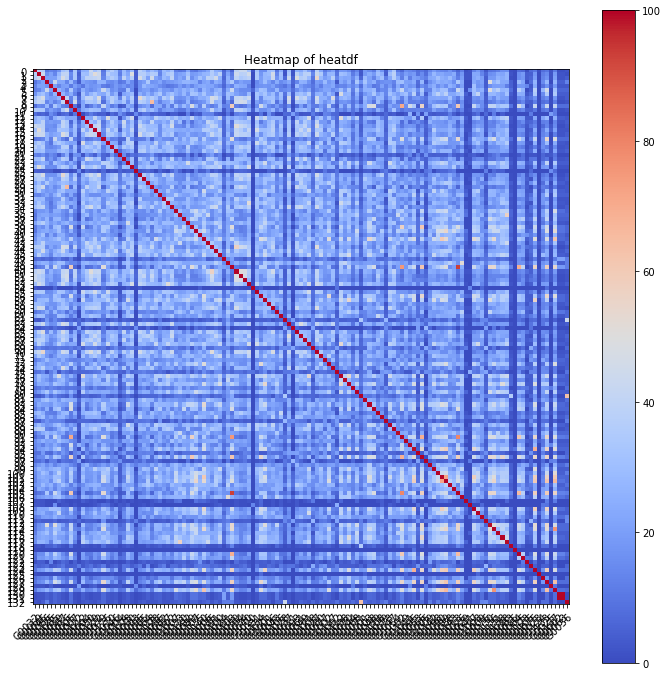

In [87]:
# Convert the Pandas DataFrame to a NumPy array
arr = heatdf.to_numpy()

# Create a heatmap using the imshow() function
fig, ax = plt.subplots()
im = ax.imshow(arr, cmap='coolwarm')

# Add a colorbar to the plot
cbar = ax.figure.colorbar(im, ax=ax)

# Set the tick labels for the x and y axes
ax.set_xticks(np.arange(len(heatdf.columns)))
ax.set_yticks(np.arange(len(heatdf.index)))
ax.set_xticklabels(heatdf.columns)
ax.set_yticklabels(heatdf.index)

# Rotate the tick labels on the x axis
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# set the size of the heatmap
fig.set_size_inches(12, 12)

# Set the plot title
ax.set_title("Heatmap of heatdf")

# Show the plot
plt.show()

array([[100,  37,  36,  10,  13,  12,  17,  32,  35,   8],
       [ 37, 100,  44,  16,  21,  14,  28,  40,  41,  15],
       [ 36,  44, 100,  21,  21,  21,  32,  47,  39,  14],
       [ 10,  16,  21, 100,  17,  43,  23,  23,  14,  28],
       [ 13,  21,  21,  17, 100,  21,  14,  20,  21,  11],
       [ 12,  14,  21,  43,  21, 100,  27,  21,  13,  34],
       [ 17,  28,  32,  23,  14,  27, 100,  27,  18,  24],
       [ 32,  40,  47,  23,  20,  21,  27, 100,  40,  13],
       [ 35,  41,  39,  14,  21,  13,  18,  40, 100,  11],
       [  8,  15,  14,  28,  11,  34,  24,  13,  11, 100]])

In [41]:
print(threat_profiles["G0042"])

{}


In [13]:
## Here we evaluate our models 
test_set = GenerateTestSet() # this is just G code and associated TTPs, need to make profiles
test_profiles = {}
test_profiles = json.load(open("datasets/ThreatProfiles/test_profiles.json"))
# create profiles using the test data and make it into a dictionary
# we filter data here to remove all empty lists
# i = 0
# for gcode, tcodes in (test_set.items()):
#     i += 1
#     if (len(tcodes) < 1):
#         continue
#     tcodes = [tc.split('.')[0] if '.' in tc else tc for tc in tcodes]
#     profile, attackPatterns, relationships = CreateRelationships(tcodes, aprioriList)
#     test_profiles[gcode] = profile

In [31]:
# topn: we consider the function a success if the atp group is identified in the top n results.
def evaluate_model(topn):
    hits = 0
    total = 0
    topn = 1

    for gcode, tcodes in test_profiles.items():
        rankings = Counter(compare_apt(tcodes, extended_threat_profiles)).most_common(topn)
        for k,v in rankings:
            if (gcode == k):
                hits += 1
                break
        total += 1

    return(hits/total)

In [40]:
evaluate_model(1)

0.8951612903225806

In [23]:
# exporting data
# with open("datasets/ThreatProfiles/threat_profiles.json", "w") as outfile:
#     json.dump(threat_profiles, outfile)

# with open("datasets/ThreatProfiles/extended_threat_profiles.json", "w") as outfile:
#     json.dump(extended_threat_profiles, outfile)

# with open("datasets/ThreatProfiles/test_profiles.json", "w") as outfile:
#     json.dump(test_profiles, outfile)

In [41]:
def json_query (extended_threat_profiles): 
    apt_list = []
    ttp_list = {}
    relationship_list = []
    for g_code, t_code_list in extended_threat_profiles.items(): 
        # Get APTs based on its G-code
        apt = src.query([Filter("external_references.external_id", "=", g_code)])[0]
        apt_list.append(apt)
        # Get TTPs based on its T-code
        for t_code, confidence in t_code_list.items():
            if (not(t_code in ttp_list.keys())):
                ttp = src.query([Filter("external_references.external_id", "=", t_code)])[0]
                ttp_list[t_code] = ttp
            conf = float(confidence)*100
            conf = str(conf) + '%'
            if (confidence > 0.85):
                #Create relationships between every TTP and a given APT
                relationship = Relationship(apt, conf, ttp_list[t_code])
                relationship_list.append(relationship)
    
    return (apt_list, list(ttp_list.values()), relationship_list)
    



In [42]:
# Save the lists
apt_sdo_list, ttp_sdo_list, relationship_sdo_list = json_query(extended_threat_profiles)

In [43]:
json_query(extended_threat_profiles)

# Print statements to verify that the query worked
print(apt_sdo_list[0])
print(ttp_sdo_list[0])
print(relationship_sdo_list[0])

{"type": "intrusion-set", "spec_version": "2.1", "id": "intrusion-set--c93fccb1-e8e8-42cf-ae33-2ad1d183913a", "created_by_ref": "identity--c78cb6e5-0c4b-4611-8297-d1b8b55e40b5", "created": "2017-05-31T21:32:03.807Z", "modified": "2022-08-23T15:30:44.196Z", "name": "Lazarus Group", "description": "[Lazarus Group](https://attack.mitre.org/groups/G0032) is a North Korean state-sponsored cyber threat group that has been attributed to the Reconnaissance General Bureau.(Citation: US-CERT HIDDEN COBRA June 2017)(Citation: Treasury North Korean Cyber Groups September 2019) The group has been active since at least 2009 and was reportedly responsible for the November 2014 destructive wiper attack against Sony Pictures Entertainment as part of a campaign named Operation Blockbuster by Novetta. Malware used by [Lazarus Group](https://attack.mitre.org/groups/G0032) correlates to other reported campaigns, including Operation Flame, Operation 1Mission, Operation Troy, DarkSeoul, and Ten Days of Rain.

In [44]:
# Global Database Driver Variable
uri = "neo4j+s://ae3c581e.databases.neo4j.io"
user = "neo4j"
password = "NIpuTQWR1jR_1EWwpCvZ-eu873ADJznwfrON5WiMwik"

driver = GraphDatabase.driver(uri, auth=(user, password))

In [45]:
def keyCheck(dictionary, key):
        if key in dictionary:
            return dictionary[key]
        else:
            return None

In [46]:
def addAPT(apt_sdo_list):
    with driver.session(database="neo4j") as session:
        for elem in apt_sdo_list:
            query = (
                "CREATE (p1:APT { spec_version: $spec_version, id: $id, created_by_ref: $created_by_ref, created: $created, modified: $modified, name: $name, description: $description, aliases: $aliases, external_references: $external_references}) "
                "RETURN p1"
            )
            result = session.run(query, spec_version = str(elem['spec_version']), id = str(elem['id']), created_by_ref = str(keyCheck(elem, 'created_by_ref')), created = str(keyCheck(elem, 'created')), modified = str(keyCheck(elem, 'modified')), name = str(keyCheck(elem, 'name')), description = str(keyCheck(elem, 'description')), aliases = str(keyCheck(elem, 'aliases')), external_references = str(keyCheck(elem, 'external_references')))

In [47]:
def addTTP(ttp_sdo_list):
        with driver.session(database="neo4j") as session:
            for elem in ttp_sdo_list:
                query = (
                    "CREATE (p1:TTP { spec_version: $spec_version, id: $id, created_by_ref: $created_by_ref, created: $created, modified: $modified, name: $name, kill_chain_phases: $kill_chain_phases, external_references: $external_references, x_mitre_is_subtechnique: $x_mitre_is_subtechnique}) "
                    "RETURN p1"
                )
                result = session.run(query, spec_version = str(elem['spec_version']), id = str(elem['id']), created_by_ref = str(keyCheck(elem, 'created_by_ref')), created = str(keyCheck(elem, 'created')), modified = str(keyCheck(elem, 'modified')), name = str(keyCheck(elem, 'name')), kill_chain_phases = str(keyCheck(elem, 'kill_chain_phases')), external_references = str(keyCheck(elem, 'external_references')), x_mitre_is_subtechnique = bool(elem['x_mitre_is_subtechnique']))

In [89]:
# Need to filter the relationships a little better -- I probably just need to query something in the GUI version
# Probably could add something about the realtionship, tbh

def addRelationship(relationship_sdo_list):
    with driver.session(database="neo4j") as session:
            for elem in relationship_sdo_list:
                rel_type = elem['relationship_type']
                
                query = (
                    "MATCH (a1: APT) "
                    "WHERE a1.id = $sourceId "
                    "MATCH (aP1: TTP) "
                    "WHERE aP1.id = $targetId "
                    "CREATE (a1)-[: USES { id: $id, confidence_level: $relationship_type, description: $description, source_ref: $source_ref, target_ref: $target_ref}]->(aP1) "
                    "RETURN a1, aP1"
                )

                
                result = session.run(query, sourceId = elem['source_ref'], targetId = elem['target_ref'], spec_version = str(keyCheck(elem, 'spec_version')), id = str(elem['id']), created_by_ref = str(keyCheck(elem, 'created_by_ref')), created = str(keyCheck(elem, 'created')), modified = str(keyCheck(elem, 'modified')), relationship_type = str(keyCheck(elem, 'relationship_type')), description = keyCheck(elem, 'description'), source_ref = str(keyCheck(elem, 'source_ref')), target_ref = str(keyCheck(elem, 'target_ref')))


In [90]:

def buildDatabase(apt_sdo_list, ttp_sdo_list, relationship_sdo_list):
    # Add the SDO nodes to the database
    addAPT(apt_sdo_list)
    addTTP(ttp_sdo_list)
    addRelationship(relationship_sdo_list)
    driver.close()
    

In [91]:

buildDatabase(apt_sdo_list, ttp_sdo_list, relationship_sdo_list)

In [44]:
# make elbow like plot
aprioriLists = AbstractTTPs(GenerateAprioriLists())

In [58]:
# run evaluations on normal threat groups
def Do_Iteration(confidence):
    confidenceLevel = confidence/100
    
    rules = AprioriMining(aprioriLists, confidenceLevel) 
    # Phase 2: Make APT Threat Profiles
    attack = Attck()

#     # Dictionary to hold all the threat profiles. 
#     # The key is a given APT and the values are a list of TTPs
#     threat_profiles = {}
#     for actor in attack.enterprise.actors:
#         technique_dict = {}
#         for technique in actor.techniques:
#             technique_dict[technique.id[0:5]] = 1
#         threat_profiles[actor.id] = technique_dict

#     # TODO: Add extended_threat profiles
#     # Create threatprofile Seed -- need to parse the value of the keys.
#     extended_threat_profiles = {}
#     for apt, t_codes in threat_profiles.items():
#         ttp_list = list(t_codes.keys())
#         profile, attackPatterns, relationships = CreateRelationships(ttp_list, rules)
#         extended_threat_profiles[apt] = profile

    # create profiles using the test data and make it into a dictionary
    # we filter data here to remove all empty lists
    test_profiles = {}
    for gcode, tcodes in (test_set.items()):
        if (tcodes == ['']):
            continue
        tcodes = [tc.split('.')[0] if '.' in tc else tc for tc in tcodes]
        profile, attackPatterns, relationships = CreateRelationships(tcodes, rules)
        test_profiles[gcode] = profile
    hits = 0
    total = 0
    topn = 1

    for gcode, tcodes in test_profiles.items():
        rankings = Counter(compare_apt(tcodes, threat_profiles)).most_common(topn)
        for k,v in rankings:
            if (gcode == k):
                hits += 1
                break
        total += 1

    return(hits/total)

In [59]:
# store results in dictionary for confidence:performance
results = {} 
# do iterations from confidence = 60 to 100
for i in range(60, 101, 1):
    print(i)
    results[i] = Do_Iteration(i)
    print(results[i])
    

60
0.8632478632478633
61
0.905982905982906
62
0.9145299145299145
63
0.9145299145299145
64
0.9145299145299145
65
0.9230769230769231
66
0.9401709401709402
67
0.9401709401709402
68
0.9487179487179487
69
0.9487179487179487
70
0.9487179487179487
71
0.9572649572649573
72
0.9572649572649573
73
0.9572649572649573
74
0.9572649572649573
75
0.9572649572649573
76
0.9572649572649573
77
0.9572649572649573
78
0.9572649572649573
79
0.9572649572649573
80
0.9572649572649573
81
0.9572649572649573
82
0.9572649572649573
83
0.9572649572649573
84
0.9572649572649573
85
0.9572649572649573
86
0.9572649572649573
87
0.9572649572649573
88
0.9572649572649573
89
0.9572649572649573
90
0.9572649572649573
91
0.9572649572649573
92
0.9572649572649573
93
0.9572649572649573
94
0.9572649572649573
95
0.9572649572649573
96
0.9572649572649573
97
0.9572649572649573
98
0.9572649572649573
99
0.9572649572649573
100
0.9572649572649573


In [60]:
with open("datasets/ThreatProfiles/results.json", "w") as outfile:
    json.dump(results, outfile)

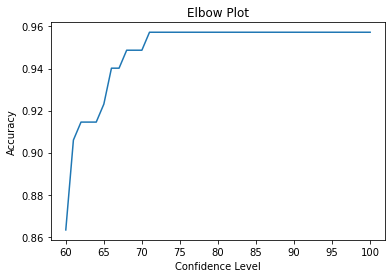

In [61]:
# extract the keys and values from the dictionary
x = list(results.keys())
y = list(results.values())

# create a line plot of the values
plt.plot(x, y)

# add labels and title
plt.xlabel('Confidence Level')
plt.ylabel('Accuracy')
plt.title('Elbow Plot')

# display the plot
plt.show()